In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy import wcs
from astropy.time import Time
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Set a site for where a camera could be
site = EarthLocation.of_site('Gemini South')

In [3]:
# let's read in a list of bright stars
names = ['id', 'identifier', 'typ', 'coord1', 'Mag U', 'Mag B', 'Mag V', 'Mag R', 'Mag I']
types = [int, 'U20', 'U20', 'U100', float, float, float, float]
star_data = np.genfromtxt('stars.dat', delimiter='|', comments='#', dtype=list(zip(names, types)))

In [4]:
# Read in stars and convert to astropy SkyCoord
coord_list = []
for star in star_data:
    coord_str = star['coord1']
    coord_str = coord_str.replace('+', ',+').replace('-', ',-')
    coords_str = coord_str.split(',')
    coord_list.append(SkyCoord(ra=coords_str[0]+' hours', dec=coords_str[1]+' degrees'))
# Here's a list of stars that we can use
coords = SkyCoord(coord_list)

In [5]:
# Construct a WCS to do the mapping of alt,az to x,y pixles on an all-sky camera
w = wcs.WCS(naxis=2)
# From previous all-sky fits
x0 = np.array([2.87e+03,   1.98e+03,  1., 1., .036,
        0.0027,  0.00295,   -0.0359])
w.wcs.crpix = [x0[0], x0[1]]
w.wcs.cdelt = [x0[2], x0[3]]
w.wcs.pc = x0[4:8].reshape((2, 2))
# While this says RA,DEC we are going to treat it as an azimuth, altitude projection
w.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]

In [6]:
# Set 3 different times to observe
mjds = np.arange(0,3,1)/24. + 35623.5 
times = Time(mjds, format='mjd')

In [7]:
# lists to hold observations
xs = []
ys = []
ras = []
decs = []
mjd_arr = []
for time in times:
    # transform stars to alt,az coords
    stars_altaz = coords.transform_to(AltAz(obstime=time, location=site))
    # Astropy is smart enough to ignore alt,az, so we have to trick it
    stars_psudo = SkyCoord(ra=stars_altaz.az, dec =stars_altaz.alt)
    # Use WCS to convert to pixel coords
    x,y = w.world_to_pixel(stars_psudo)
    # only use stars that land on the chip (say it's 4kx4k) and are above the horizon
    on_chip = np.where((x > 0) & (x < 4000) & (y > 0) & (y < 4000) & (stars_altaz.alt.value > 0))[0]
    xs.append(x[on_chip])
    ys.append(y[on_chip])
    mjd_arr.append([time.mjd]*len(x[on_chip]))
    ras.append(coords.ra.value[on_chip])
    decs.append(coords.dec.value[on_chip])
xs = np.concatenate(xs)
ys = np.concatenate(ys)
mjd_arr = np.concatenate(mjd_arr)

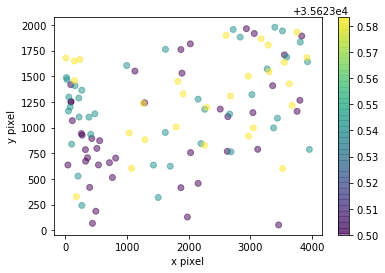

In [8]:
# plot the position of stars on the camera, color-coded by time of observation
plt.scatter(xs, ys, c=mjd_arr, alpha=0.5)
plt.xlabel('x pixel')
plt.ylabel('y pixel')
cb = plt.colorbar()

In [9]:
# Let's make sure we can convert things back
recovered_alt_az = w.pixel_to_world(xs, ys) # but it thinks it's RA, Dec.
ras_back = []
decs_back = []
for mjd in np.unique(mjd_arr):
    in_time = np.where(mjd_arr == mjd)
    stars_temp = AltAz(alt=recovered_alt_az.dec[in_time], az=recovered_alt_az.ra[in_time],
                       location=site, obstime=Time(mjd, format='mjd'))
    stars_ra_dec_temp = stars_temp.transform_to(ICRS)
    ras_back.append(stars_ra_dec_temp.ra.value)
    decs_back.append(stars_ra_dec_temp.dec.value)
    
ras_back = np.concatenate(ras_back)
decs_back = np.concatenate(decs_back)

In [10]:
ra_resid = np.concatenate(ras) - ras_back
dec_resid = np.concatenate(decs) - decs_back

In [11]:
# ok, these should all be nice and small
ra_resid, dec_resid

(array([ 5.49569279e-11,  5.37951905e-11, -6.09361450e-11, -6.09361450e-11,
         2.76365597e-11,  1.28159705e-11, -5.79234438e-11,  4.34958736e-11,
        -6.32098818e-11, -4.92832442e-11, -5.77529136e-11, -1.58593139e-11,
         2.50470755e-11,  5.92024207e-11,  5.98099348e-11, -1.70530257e-11,
         1.97846184e-11, -2.88196134e-11,  4.50839366e-11,  2.33910669e-11,
         1.19371180e-12, -4.54747351e-12,  2.46416221e-11,  2.45563569e-11,
         5.11590770e-12,  3.41060513e-12, -1.59161573e-12,  2.54658516e-11,
        -2.54090082e-11, -1.47224455e-11, -2.34194886e-11, -4.61000127e-11,
        -2.73416845e-11, -4.23483471e-11, -4.93969310e-11, -6.04813977e-11,
        -4.34852154e-11, -6.42330633e-11,  4.99653652e-11,  4.37125891e-11,
         6.87805368e-12,  3.92219590e-12,  3.81454868e-11,  5.06972242e-11,
         1.17417187e-12, -1.40487622e-11,  4.87290208e-11,  5.09317033e-11,
         5.51025892e-11,  5.21680477e-11,  5.16635623e-11, -6.40056896e-11,
        -6.5

Text(0, 0.5, 'Dec (deg)')

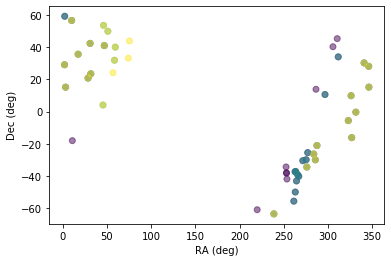

In [12]:
# most stars have three overlapping points. Some are all yellow (they were observed once and set),
# and some are purple (stars that rose and were only in the final image)
# (normally we would want to use a projection of some kind when plotting RA,Dec, but this is just a quick look)
plt.scatter(ras_back, decs_back, c=mjd_arr, alpha=.5)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

In [13]:
# So, we showed we can round-trip the transformation of coordinates, let's see what happens if our WCS is slightly off

w_off = wcs.WCS(naxis=2)
# Same as before, but shift the reference pixel by 200 in both x and y and fiddle with the other values too
x0 = np.array([2.87e+03 + 200,   1.98e+03 - 200,  1., 1., .036+.002,
        0.0027+.0002,  0.00295,   -0.0359])
w_off.wcs.crpix = [x0[0], x0[1]]
w_off.wcs.cdelt = [x0[2], x0[3]]
w_off.wcs.pc = x0[4:8].reshape((2, 2))
# While this says RA, DEC, we are going to treat it as an azimuth, altitude projection
w_off.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]

In [14]:
# same as before, only now using the slightly wrong WCS object
recovered_alt_az = w_off.pixel_to_world(xs, ys)
ras_back = []
decs_back = []
for mjd in np.unique(mjd_arr):
    in_time = np.where(mjd_arr == mjd)
    stars_temp = AltAz(alt=recovered_alt_az.dec[in_time], az=recovered_alt_az.ra[in_time],
                       location=site, obstime=Time(mjd, format='mjd'))
    stars_ra_dec_temp = stars_temp.transform_to(ICRS)
    ras_back.append(stars_ra_dec_temp.ra.value)
    decs_back.append(stars_ra_dec_temp.dec.value)
ras_back = np.concatenate(ras_back)
decs_back = np.concatenate(decs_back)

/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/astropy/_erfa/core.py:4118: RuntimeWarning: invalid value encountered in atoiq
  ri, di = ufunc.atoiq(type, ob1, ob2, astrom)
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/astropy/_erfa/core.py:4212: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/astropy/_erfa/core.py:17885: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)


Text(0, 0.5, 'Dec (deg)')

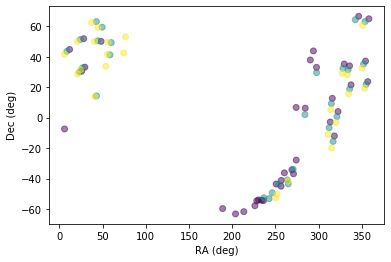

In [15]:
# Now the stars are spread out in RA,Dec because the transformation was slightly off.
plt.scatter(ras_back, decs_back, c=mjd_arr, alpha=0.5)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

So, the challenge: Can we create a function that takes arrays of star x,y,mjd values, the observatory location, and an initial WCS guess and solve for a best fitting WCS solution that maps x,y to alt,az. We can also think about including the stars' magnitude (and correcting for airmass extinction), or the precision we think we can centroid stars to. An important point is that I don't think we have to include any reference star positions!

We will need to define some statistic to minimize and pick an optimization algorithm (probably from scipy.minimize). Probably something to do with the spread of points in the RA,Dec,mjd space. The tricky part will be making sure it's fast enough. The astropy coordinate conversion calls can be slow, and it's easy to make lots of unneeded computations when computing our statistic.  The other trick is making sure our statistic is robust to stars that don't appear in multiple images (or other outliers like cosmic ray hits that are mistaken for stars). 

If we can do it, it would be a useful tool both for Rubin Observatory and the general astronomical community. The astrometry.net service specializes in fitting WCS solutions to images, but struggles with all-sky camera images. I think we could make this a contribution to astropy and they would be happy to merge it in with their code.